<a href="https://colab.research.google.com/github/AnastasiaBrinati/Progetto-ML-23-24/blob/main/task2_federato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TASK 2 FEDERATED

###Imports

In [2]:
!pip install -q flwr["simulation"] tensorflow
!pip install -q flwr_datasets["vision"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 10.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.25.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 M

Let's also install Matplotlib so we can make some plots once the simulation is completed

In [3]:
!pip install matplotlib

Next, we import the required dependencies. The most important imports are Flower (`flwr`) and TensorFlow:

In [4]:
from typing import Dict, List, Tuple

import tensorflow as tf

import flwr as fl
from flwr.common import Metrics
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth

from datasets import Dataset
from flwr_datasets import FederatedDataset

VERBOSE = 0
NUM_CLIENTS = 100

In [5]:
import tensorflow as tf

from tensorflow import keras
from keras import layers

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

## Model

It is good practice to normalize features that use different scales and ranges.

One reason this is important is because the features are multiplied by the model weights. So, the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

Although a model *might* converge without feature normalization, normalization makes training much more stable.

Note: There is no advantage to normalizing the one-hot features—it is done here for simplicity. For more details on how to use the preprocessing layers, refer to the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.

### Building the DNN

In [7]:
def get_model():

    """Constructs a model suitable."""
    # Define input layers for all the features
    mwg_input = tf.keras.layers.Input(shape=(1,), name='MWG')
    nwg_input = tf.keras.layers.Input(shape=(1,), name='NWG')
    kwg_input = tf.keras.layers.Input(shape=(1,), name='KWG')
    mdimc_input = tf.keras.layers.Input(shape=(1,), name='MDIMC')
    ndimc_input = tf.keras.layers.Input(shape=(1,), name='NDIMC')
    mdima_input = tf.keras.layers.Input(shape=(1,), name='MDIMA')
    ndimb_input = tf.keras.layers.Input(shape=(1,), name='NDIMB')
    kwi_input = tf.keras.layers.Input(shape=(1,), name='KWI')
    vwm_input = tf.keras.layers.Input(shape=(1,), name='VWM')
    vwn_input = tf.keras.layers.Input(shape=(1,), name='VWN')
    strm_input = tf.keras.layers.Input(shape=(1,), name='STRM')
    strn_input = tf.keras.layers.Input(shape=(1,), name='STRN')
    sa_input = tf.keras.layers.Input(shape=(1,), name='SA')
    sb_input = tf.keras.layers.Input(shape=(1,), name='SB')


    # Concatenate the input tensors
    concatenated_inputs = tf.keras.layers.concatenate([mwg_input, nwg_input,kwg_input,mdimc_input,
                                                       ndimc_input,mdima_input,ndimb_input,kwi_input,
                                                       vwm_input,vwn_input,strm_input,strn_input,
                                                       sa_input,sb_input
                                                       ])

    # Define the rest of the model
    x = tf.keras.layers.Flatten()(concatenated_inputs)

    #      'num_layers': 2,
    #      'units_0': 128,
    #      'activation_0': 'sigmoid',
    #      'units_1': 128,
    #      'activation_1': 'sigmoid',
    #      'units_2': 112,
    #      'activation_2': 'PReLU',
    #      'learning_rate': 0.01,
    #      'units_3': 96,
    #      'activation_3': 'sigmoid'

    x = tf.keras.layers.Dense(128, activation="sigmoid")(x)
    x = tf.keras.layers.Dense(128, activation="sigmoid")(x)

    output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    # Construct the model
    model = tf.keras.models.Model(inputs=[mwg_input, nwg_input,kwg_input,mdimc_input,
                                          ndimc_input,mdima_input,ndimb_input,kwi_input,
                                          vwm_input,vwn_input,strm_input,strn_input,
                                          sa_input,sb_input], outputs=output)

    # Compile the model
    model.compile(loss='mean_absolute_error', optimizer=tf.keras.optimizers.Adam(0.01), metrics=["mse", "mape", "mean_squared_logarithmic_error","R2Score"])

    return model

# come era prima:
      #model = keras.Sequential([
      #layers.Flatten(),
      #layers.Dense(16, activation='relu', name="uno"),  #input_shape=(2, 32,15)
      #layers.Dense(1, name="ultimo"),

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
#dnn_model = get_model(normalizer)
dnn_model = get_model()
dnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 MWG (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 NWG (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 KWG (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 MDIMC (InputLayer)          [(None, 1)]                  0         []                            
                                                                                              

## Clients

With that out of the way, let's move on to the interesting bits. Federated learning systems consist of a server and multiple clients. In Flower, we create clients by implementing subclasses of `flwr.client.Client` or `flwr.client.NumPyClient`. We use `NumPyClient` in this tutorial because it is easier to implement and requires us to write less boilerplate.

To implement the Flower client, we create a subclass of `flwr.client.NumPyClient` and implement the three methods `get_parameters`, `fit`, and `evaluate`:

- `get_parameters`: Return the current local model parameters
- `fit`: Receive model parameters from the server, train the model parameters on the local data, and return the (updated) model parameters to the server
- `evaluate`: Received model parameters from the server, evaluate the model parameters on the local data, and return the evaluation result to the server

We mentioned that our clients will use TensorFlow/Keras for the model training and evaluation. Keras models provide methods that make the implementation straightforward: we can update the local model with server-provides parameters through `model.set_weights`, we can train/evaluate the model through `fit/evaluate`, and we can get the updated model parameters through `model.get_weights`.

Let's see a simple implementation:

In [9]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainset, valset) -> None:
        # Create model
        self.model = get_model()
        self.trainset = trainset
        self.valset = valset

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(self.trainset, epochs=1, verbose=VERBOSE)
        return self.model.get_weights(), len(self.trainset), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        results = self.model.evaluate(self.valset) #, verbose=VERBOSE)

        loss = results[0]
        mse = results[1]
        mape = results[2]
        mean_squared_logarithmic_error = results[3]
        r2score = results[4]

        # return {"loss": loss, "mse": mse, "mape": mape, "mean_squared_logarithmic_error":mean_squared_logarithmic_error, "R2Score": r2score}
        return loss, len(self.valset), {"loss": loss, "mse": mse, "mape": mape, "mean_squared_logarithmic_error": mean_squared_logarithmic_error, "R2Score": r2score}

Our class `FlowerClient` defines how local training/evaluation will be performed and allows Flower to call the local training/evaluation through `fit` and `evaluate`. Each instance of `FlowerClient` represents a *single client* in our federated learning system. Federated learning systems have multiple clients (otherwise, there's not much to federate, is there?), so each client will be represented by its own instance of `FlowerClient`. If we have, for example, three clients in our workload, we'd have three instances of `FlowerClient`. Flower calls `FlowerClient.fit` on the respective instance when the server selects a particular client for training (and `FlowerClient.evaluate` for evaluation).

In this notebook, we want to simulate a federated learning system with 100 clients on a single machine. This means that the server and all 100 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 100 clients would mean having 100 instances of `FlowerClient` in memory. Doing this on a single machine can quickly exhaust the available memory resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, we need to implement a function called `client_fn` that creates a `FlowerClient` instance on demand. Flower calls `client_fn` whenever it needs an instance of one particular client to call `fit` or `evaluate` (those instances are usually discarded after use). Clients are identified by a client ID, or short `cid`. The `cid` can be used, for example, to load different local data partitions for each client

##Strategy

We now define four auxiliary functions for this example (note the last two are entirely optional):
* `get_client_fn()`: Is a function that returns another function. The returned `client_fn` will be executed by Flower's VirtualClientEngine each time a new _virtual_ client (i.e. a client that is simulated in a Python process) needs to be spawn. When are virtual clients spawned? Each time the strategy samples them to do either `fit()` (i.e. train the global model on the local data of a particular client) or `evaluate()` (i.e. evaluate the global model on the validation set of a given client).

* `weighted_average()`: This is an optional function to pass to the strategy. It will be executed after an evaluation round (i.e. when client run `evaluate()`) and will aggregate the metrics clients return. In this example, we use this function to compute the weighted average accuracy of clients doing `evaluate()`.

* `get_evaluate_fn()`: This is again a function that returns another function. The returned function will be executed by the strategy at the end of a `fit()` round and after a new global model has been obtained after aggregation. This is an optional argument for Flower strategies. In this example, we use the whole MNIST test set to perform this server-side evaluation.

In [9]:
"""Returns a function to construct a client.
    The VirtualClientEngine will execute this function whenever a client is sampled by the strategy to participate. """

def get_client_fn(dataset: FederatedDataset):

    def client_fn(cid: str) -> fl.client.Client:
        """Construct a FlowerClient with its own dataset partition."""

        # Extract partition for client with id = cid
        # !!!!!!!!
        client_dataset = dataset.load_partition(int(cid), "train")

        # Now let's split it into train (80%) and validation (20%)
        client_dataset_splits = client_dataset.train_test_split(test_size=0.2)

        train_set = client_dataset_splits["train"].to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=32)
        val_set = client_dataset_splits["test"].to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=64)


        # Create and return client
        return FlowerClient(train_set, val_set).to_client()

    return client_fn

In [10]:
"""Aggregation function for (federated) evaluation metrics, i.e. those returned by the client's evaluate() method."""

def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply metric of each client by number of examples used

    #losses = [num_examples * m["loss"] for num_examples, m in metrics]
    mses = [num_examples * m["mse"] for num_examples, m in metrics]
    mapes = [num_examples * m["mape"] for num_examples, m in metrics]
    mean_squared_logarithmic_errors = [num_examples * m["mean_squared_logarithmic_error"] for num_examples, m in metrics]
    R2Scores = [num_examples * m["R2Score"] for num_examples, m in metrics]

    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"mse": sum(mses) / sum(examples), "mape": sum(mapes) / sum(examples), "mean_squared_logarithmic_error": sum(mean_squared_logarithmic_errors) / sum(examples),"R2Score": sum(R2Scores) / sum(examples)}

In [11]:
"""Returns an evaluation function for server-side (i.e. centralised) evaluation."""

def get_evaluate_fn(testset: Dataset):
    # The `evaluate` function will be called after every round by the strategy
    def evaluate(server_round: int, parameters: fl.common.NDArrays, config: Dict[str, fl.common.Scalar]):
        model = get_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        aiuto = model.evaluate(testset) #, verbose=VERBOSE)
        # return {"loss": res['loss'], "mse": res['mse'], "mape": res['mape'], "mean_squared_logarithmic_error": res['mean_squared_logarithmic_error'], "R2Score": res['R2Score']}
        # return {"loss": loss, "mse": res[0], "mape": res[1], "mean_squared_logarithmic_error": res[2], "R2Score": res[3]}
        # return {"loss": aiuto[0], "mse": aiuto[1], "mape": aiuto[2], "mean_squared_logarithmic_error": aiuto[3], "R2Score": aiuto[4]}
        return aiuto[0], {"mse": aiuto[1], "mape": aiuto[2], "mean_squared_logarithmic_error": aiuto[3], "R2Score": aiuto[4]}

    return evaluate

We now have `FlowerClient` which defines client-side training and evaluation, and `client_fn`, which allows Flower to create `FlowerClient` instances whenever it needs to call `fit` or `evaluate` on one particular client. The last step is to start the actual simulation using `flwr.simulation.start_simulation`.

In [14]:

# Simulation parameters
settings = {
    "VERBOSE": 0,
    "NUM_CLIENTS": 5,
    "FRACTION_FIT": 0.8,
    "FRACTION_EVALUATE": 0.2,
    "MIN_FIT_CLIENTS": 5,
    "MIN_EVALUATE_CLIENTS": 2,
    "MIN_AVAILABLE_CLIENTS_FRACTION": 0.5,
    "STRATEGY_TYPE": 'QFedAvg', # QFedAvg, FedAvg, FedProx
    "NUM_ROUNDS": 10
}

In [25]:
# Create FedAvg strategy

def get_strategy(centralized_testset):

  #strategy = fl.server.strategy.FedAvg(
  #   fraction_fit=0.1,  # Sample 10% of available clients for training
  #   fraction_evaluate=0.05,  # Sample 5% of available clients for evaluation
  #   min_fit_clients=10,  # Never sample less than 10 clients for training
  #   min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
  #   min_available_clients=int(NUM_CLIENTS * 0.5),  # Wait until at least 75 clients are available
  #   evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
  #   evaluate_fn=get_evaluate_fn(centralized_testset),  # global evaluation function
  #)

  #strategy = fl.server.strategy.FedProx(
  #  proximal_mu=1.0,
  #  fraction_fit=settings["FRACTION_FIT"],
  #  fraction_evaluate=settings["FRACTION_EVALUATE"],
  #  min_fit_clients=settings["MIN_FIT_CLIENTS"],
  #  min_evaluate_clients=settings["MIN_EVALUATE_CLIENTS"],
  #  min_available_clients=int(settings["NUM_CLIENTS"] * settings["MIN_AVAILABLE_CLIENTS_FRACTION"]),
  #  evaluate_metrics_aggregation_fn=weighted_average,
  #  evaluate_fn=get_evaluate_fn(centralized_testset),
  #)

  strategy = fl.server.strategy.QFedAvg(
    fraction_fit=settings["FRACTION_FIT"],
    fraction_evaluate=settings["FRACTION_EVALUATE"],
    min_fit_clients=settings["MIN_FIT_CLIENTS"],
    min_evaluate_clients=settings["MIN_EVALUATE_CLIENTS"],
    min_available_clients=int(settings["NUM_CLIENTS"] * settings["MIN_AVAILABLE_CLIENTS_FRACTION"]),
    evaluate_metrics_aggregation_fn=weighted_average,
    evaluate_fn=get_evaluate_fn(centralized_testset),
  )

  return strategy

## Start the Simulation

The function `start_simulation` accepts a number of arguments, amongst them the `client_fn` used to create `FlowerClient` instances, the number of clients to simulate `num_clients`, the number of rounds `num_rounds`, and the strategy. The strategy encapsulates the federated learning approach/algorithm, for example, *Federated Averaging* (FedAvg).

Flower comes with a number of built-in strategies, but we can also use our own strategy implementations to customize nearly all aspects of the federated learning approach. For this example, we use the built-in `FedAvg` implementation and customize it using a few basic parameters. The last step is the actual call to `start_simulation` which - you guessed it - actually starts the simulation.

We can use [Flower Datasets](https://flower.dev/docs/datasets/) to effortlessly obtain an off-the-shelf partitioned dataset or partition one that isn't pre-partitioned. Let's choose MNIST.

In [ ]:
# Enable GPU growth in your main process
enable_tf_gpu_growth()

# Download our dataset and partition it
gpus_fds = FederatedDataset(dataset="anastasiafrosted/gpus", partitioners={"train": NUM_CLIENTS})
# Get the whole test set for centralised evaluation
#print(column_names)
centralized_testset = gpus_fds.load_full("test").to_tf_dataset(columns=['MWG', 'NWG', 'KWG', 'MDIMC', 'NDIMC', 'MDIMA', 'NDIMB', 'KWI', 'VWM',
       'VWN', 'STRM', 'STRN', 'SA', 'SB'], label_cols=['avg_runs'], batch_size=64)

# get the strategy
strategy = get_strategy(centralized_testset)

In [ ]:
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 2, "num_gpus": 0.0}

# Start simulation
history = fl.simulation.start_simulation(
    client_fn=get_client_fn(gpus_fds),
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=10),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
)

In [ ]:
print(f"{history.losses_centralized = }")

# PLOT

In [10]:
import matplotlib.pyplot as plt

def plot_loss(history):
  fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(19, 5))

  ax1.plot(pd.DataFrame(history.c_loss), label='loss_centralizzata')
  ax1.plot(pd.DataFrame(history.loss_avg), label='loss_avg')
  ax1.plot(pd.DataFrame(history.loss_prox), label='loss_prox')
  ax1.plot(pd.DataFrame(history.loss_qavg), label='loss_qavg')

  ax2.plot(pd.DataFrame(history.c_mse), label='mse_centralized')
  ax2.plot(pd.DataFrame(history.mse_avg), label='mse_avg')
  ax2.plot(pd.DataFrame(history.mse_prox), label='mse_prox')
  ax2.plot(pd.DataFrame(history.mse_qavg), label='mse_qavg')

  ax3.plot(pd.DataFrame(history.c_mape), label='mape_centralized')
  ax3.plot(pd.DataFrame(history.mape_avg), label='mape_avg')
  ax3.plot(pd.DataFrame(history.mape_prox), label='mape_prox')
  ax3.plot(pd.DataFrame(history.mape_qavg), label='mape_qavg')

  ax4.plot(pd.DataFrame(history.c_msle), label='msle_centralized')
  ax4.plot(pd.DataFrame(history.msle_avg), label='msle_avg')
  ax4.plot(pd.DataFrame(history.msle_prox), label='msle_prox')
  ax4.plot(pd.DataFrame(history.msle_qavg), label='msle_qavg')

  ax5.plot(pd.DataFrame(history.c_r2), label='r2_centralized')
  ax5.plot(pd.DataFrame(history.r2_avg), label='r2_avg')
  ax5.plot(pd.DataFrame(history.r2_prox), label='r2_prox')
  ax5.plot(pd.DataFrame(history.r2_qavg), label='r2_qavg')

  ax1.set(xlabel='Epoch', ylabel='loss')
  ax1.legend(loc="upper right")
  ax1.grid(True)

  ax2.set(xlabel='Epoch', ylabel='mse')
  ax2.legend(loc="upper right")
  ax2.grid(True)

  ax3.set(xlabel='Epoch', ylabel='mape')
  ax3.legend(loc="upper right")
  ax3.grid(True)

  ax4.set(xlabel='Epoch', ylabel='mean_squared_logarithmic_error')
  ax4.legend(loc="upper right")
  ax4.grid(True)

  ax5.set(xlabel='Epoch', ylabel='r2_score')
  ax5.legend(loc="upper right")
  ax5.grid(True)

  fig.tight_layout()

#### CENTRALE

In [11]:
# initialize list of lists
data_centrale = [[0, 0, 0, 0, 0, 0],
                [1,0.654691,3.148931,84.439003,0.158293,0.179876],
                [2,0.638235,3.136050,79.750023,0.154645,0.183230],
                [3,0.631250,3.132224,77.709427,0.152647,0.184227],
                [4,0.620261,3.123100,80.765099,0.148184,0.186603],
                [5,0.616670,3.121987,78.399124,0.147527,0.186893],
                [6,0.620576,3.122755,93.155891,0.147896,0.186693],
                [7,0.613600,3.121242,78.342842,0.147210,0.187087],
                [8,0.613441,3.121131,79.306496,0.147167,0.187116],
                [9,0.611118,3.120584,76.801743,0.146897,0.187258],
                [10,0.611208,3.120517,77.030296,0.146838,0.187276]]

# Create the pandas DataFrame
h_centrale = pd.DataFrame(data_centrale, columns=['epoch','c_loss', 'c_mse', 'c_mape', 'c_msle','c_r2']).drop(0)

h_centrale

,epoch,c_loss,c_mse,c_mape,c_msle,c_r2
1,1,0.654691,3.148931,84.439003,0.158293,0.179876
2,2,0.638235,3.136050,79.750023,0.154645,0.183230
3,3,0.631250,3.132224,77.709427,0.152647,0.184227
4,4,0.620261,3.123100,80.765099,0.148184,0.186603
5,5,0.616670,3.121987,78.399124,0.147527,0.186893
6,6,0.620576,3.122755,93.155891,0.147896,0.186693
7,7,0.613600,3.121242,78.342842,0.147210,0.187087
8,8,0.613441,3.121131,79.306496,0.147167,0.187116
9,9,0.611118,3.120584,76.801743,0.146897,0.187258
10,10,0.611208,3.120517,77.030296,0.146838,0.187276


# SIMULAZIONE 10 CLIENTS

#### AVG

In [49]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})
h_fedavg

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(typ

,r2score,mse,mape,msle,loss (mae)
0,-0.012253,3.959210,1462.705078,0.349551,1.068121
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601


In [50]:
h_fedavg
h_avg = h_fedavg.drop(0)
h_avg = h_avg.rename(columns={'r2score': 'r2_avg', 'mse': 'mse_avg', 'mape': 'mape_avg', 'msle': 'msle_avg', 'loss (mae)': 'loss_avg'})
h_avg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_avg,mse_avg,mape_avg,msle_avg,loss_avg
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601
10,0.174395,3.229178,99.611504,0.166774,0.677603


#### PROX

In [51]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle_prox'})
h_prox = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss_prox'})
h_prox

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(typ

,r2_prox,mse_prox,mape_prox,msle_prox,loss_prox
0,-0.012253,3.959210,1462.705078,0.349551,1.068121
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601


In [52]:
h_prox = h_prox.drop(0)
h_prox

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_prox,mse_prox,mape_prox,msle_prox,loss_prox
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601
10,0.174395,3.229178,99.611504,0.166774,0.677603


#### Q AVG

In [53]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedQavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})
h_fedQavg

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(typ

,r2score,mse,mape,msle,loss (mae)
0,-0.012253,3.959210,1462.705078,0.349551,1.068121
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601


In [54]:
h_qavg = h_fedQavg.drop(0)
h_qavg = h_qavg.rename(columns={'r2score': 'r2_qavg', 'mse': 'mse_qavg', 'mape': 'mape_qavg', 'msle': 'msle_qavg', 'loss (mae)': 'loss_qavg'})
h_qavg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_qavg,mse_qavg,mape_qavg,msle_qavg,loss_qavg
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601
10,0.174395,3.229178,99.611504,0.166774,0.677603


#### COMPLETE

In [55]:
data_average = [[0, 0, 0, 0, 0],
                [-0.159771,4.536193,100.004440,0.487902,0.934440],
                [-0.159773,4.536201,99.999908,0.487908,0.934440],
                [-0.159774,4.536206,99.999817	,0.487910,0.934440],
                [-0.159762,4.536160	,100.015480,0.487887,0.934439],
                [-0.159739,4.536069,100.035339,0.487848,0.934431],
                [0.113972,3.465510,151.377197,0.221914,0.768952],
                [0.172852,3.235211,131.229401,0.167273,0.687880],
                [0.1737141,3.231839,109.219765,0.167129,0.682031],
                [0.173618,3.232217,102.129463,0.167961,0.681446],
                [0.173676,3.231989,101.123550,0.167977,0.681023]]

# Create the pandas DataFrame
h_average = pd.DataFrame(data_average, columns=['r2_avg', 'mse_avg', 'mape_avg', 'msle_avg','loss_avg']).drop(0)

h_average

,r2_avg,mse_avg,mape_avg,msle_avg,loss_avg
1,-0.159771,4.536193,100.004440,0.487902,0.934440
2,-0.159773,4.536201,99.999908,0.487908,0.934440
3,-0.159774,4.536206,99.999817,0.487910,0.934440
4,-0.159762,4.536160,100.015480,0.487887,0.934439
5,-0.159739,4.536069,100.035339,0.487848,0.934431
6,0.113972,3.465510,151.377197,0.221914,0.768952
7,0.172852,3.235211,131.229401,0.167273,0.687880
8,0.173714,3.231839,109.219765,0.167129,0.682031
9,0.173618,3.232217,102.129463,0.167961,0.681446
10,0.173676,3.231989,101.123550,0.167977,0.681023


In [56]:
data_proxima = [[0, 0, 0, 0, 0],
                [-0.159761,	4.536156,	100.018501,	0.487884,	0.934440],
                [-0.159761,	4.536155,	100.016670,	0.487885,	0.934439],
                [-0.156000,	4.521444,	101.676048,	0.482388,	0.932707],
                [0.167904,	3.254565,	152.828018,	0.171608,	0.702200],
                [0.173137,	3.234097,	113.124878,	0.167332,	0.684588],
                [0.174238,	3.229789,	112.388069,	0.166447,	0.680393],
                [0.174250,	3.229745,	103.766556,	0.166798,	0.678801],
                [0.174194,	3.229962,	94.614578,	0.167129,	0.677484],
                [0.174422,	3.229069,	99.866089,	0.166694,	0.6774036],
                [0.174435,	3.229018,	100.721138,	0.166633,	0.677700]]

# Create the pandas DataFrame
h_proxima = pd.DataFrame(data_proxima, columns=['r2_prox', 'mse_prox', 'mape_prox', 'msle_prox','loss_prox']).drop(0)

h_proxima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_prox,mse_prox,mape_prox,msle_prox,loss_prox
1,-0.159761,4.536156,100.018501,0.487884,0.934440
2,-0.159761,4.536155,100.016670,0.487885,0.934439
3,-0.156000,4.521444,101.676048,0.482388,0.932707
4,0.167904,3.254565,152.828018,0.171608,0.702200
5,0.173137,3.234097,113.124878,0.167332,0.684588
6,0.174238,3.229789,112.388069,0.166447,0.680393
7,0.174250,3.229745,103.766556,0.166798,0.678801
8,0.174194,3.229962,94.614578,0.167129,0.677484
9,0.174422,3.229069,99.866089,0.166694,0.677404
10,0.174435,3.229018,100.721138,0.166633,0.677700


In [57]:
data_qaverage = [[0, 0, 0, 0, 0],
                [-0.031207,	4.033346,	1132.671509,	0.343593,	1.019538],
                [-0.036612,	4.054486,	1061.246216,	0.344469,	1.010093],
                [-0.042373,	4.077017,	991.136658,	0.346226,	1.001300],
                [-0.048187,	4.099756,	925.199341,	0.348730,	0.993504],
                [-0.054264,	4.123526,	860.745056,	0.352047,	0.986335],
                [-0.060409,	4.147560,	799.517822,	0.356052,	0.980197],
                [-0.066422,	4.171080,	742.745605,	0.360552,	0.975025],
                [-0.072392,	4.194432,	689.080811,	0.365548,	0.970338],
                [-0.078135,	4.216892,	639.531616,	0.370819,	0.966136],
                [-0.083190,	4.236665,	597.274475,	0.375822,	0.962644]]

# Create the pandas DataFrame
h_qaverage = pd.DataFrame(data_qaverage, columns=['r2_qavg', 'mse_qavg', 'mape_qavg', 'msle_qavg','loss_qavg']).drop(0)

h_qaverage

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_qavg,mse_qavg,mape_qavg,msle_qavg,loss_qavg
1,-0.031207,4.033346,1132.671509,0.343593,1.019538
2,-0.036612,4.054486,1061.246216,0.344469,1.010093
3,-0.042373,4.077017,991.136658,0.346226,1.001300
4,-0.048187,4.099756,925.199341,0.348730,0.993504
5,-0.054264,4.123526,860.745056,0.352047,0.986335
6,-0.060409,4.147560,799.517822,0.356052,0.980197
7,-0.066422,4.171080,742.745605,0.360552,0.975025
8,-0.072392,4.194432,689.080811,0.365548,0.970338
9,-0.078135,4.216892,639.531616,0.370819,0.966136
10,-0.083190,4.236665,597.274475,0.375822,0.962644


In [58]:
complete_h = pd.concat([h_centrale, h_average], axis=1)
complete_h = pd.concat([complete_h, h_proxima], axis=1)
complete_h = pd.concat([complete_h, h_qaverage], axis=1)

complete_h = complete_h.iloc[:,[0,1,10,15,20,2,7,12,17,3,8,13,18,4,9,14,19,5,6,11,16]]

pd.set_option('display.max_columns', None)
complete_h

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,epoch,c_loss,loss_avg,loss_prox,loss_qavg,c_mse,mse_avg,mse_prox,mse_qavg,c_mape,mape_avg,mape_prox,mape_qavg,c_msle,msle_avg,msle_prox,msle_qavg,c_r2,r2_avg,r2_prox,r2_qavg
1,1,0.654691,0.934440,0.934440,1.019538,3.148931,4.536193,4.536156,4.033346,84.439003,100.004440,100.018501,1132.671509,0.158293,0.487902,0.487884,0.343593,0.179876,-0.159771,-0.159761,-0.031207
2,2,0.638235,0.934440,0.934439,1.010093,3.136050,4.536201,4.536155,4.054486,79.750023,99.999908,100.016670,1061.246216,0.154645,0.487908,0.487885,0.344469,0.183230,-0.159773,-0.159761,-0.036612
3,3,0.631250,0.934440,0.932707,1.001300,3.132224,4.536206,4.521444,4.077017,77.709427,99.999817,101.676048,991.136658,0.152647,0.487910,0.482388,0.346226,0.184227,-0.159774,-0.156000,-0.042373
4,4,0.620261,0.934439,0.702200,0.993504,3.123100,4.536160,3.254565,4.099756,80.765099,100.015480,152.828018,925.199341,0.148184,0.487887,0.171608,0.348730,0.186603,-0.159762,0.167904,-0.048187
5,5,0.616670,0.934431,0.684588,0.986335,3.121987,4.536069,3.234097,4.123526,78.399124,100.035339,113.124878,860.745056,0.147527,0.487848,0.167332,0.352047,0.186893,-0.159739,0.173137,-0.054264
6,6,0.620576,0.768952,0.680393,0.980197,3.122755,3.465510,3.229789,4.147560,93.155891,151.377197,112.388069,799.517822,0.147896,0.221914,0.166447,0.356052,0.186693,0.113972,0.174238,-0.060409
7,7,0.613600,0.687880,0.678801,0.975025,3.121242,3.235211,3.229745,4.171080,78.342842,131.229401,103.766556,742.745605,0.147210,0.167273,0.166798,0.360552,0.187087,0.172852,0.174250,-0.066422
8,8,0.613441,0.682031,0.677484,0.970338,3.121131,3.231839,3.229962,4.194432,79.306496,109.219765,94.614578,689.080811,0.147167,0.167129,0.167129,0.365548,0.187116,0.173714,0.174194,-0.072392
9,9,0.611118,0.681446,0.677404,0.966136,3.120584,3.232217,3.229069,4.216892,76.801743,102.129463,99.866089,639.531616,0.146897,0.167961,0.166694,0.370819,0.187258,0.173618,0.174422,-0.078135
10,10,0.611208,0.681023,0.677700,0.962644,3.120517,3.231989,3.229018,4.236665,77.030296,101.123550,100.721138,597.274475,0.146838,0.167977,0.166633,0.375822,0.187276,0.173676,0.174435,-0.083190


#### GRAFICI

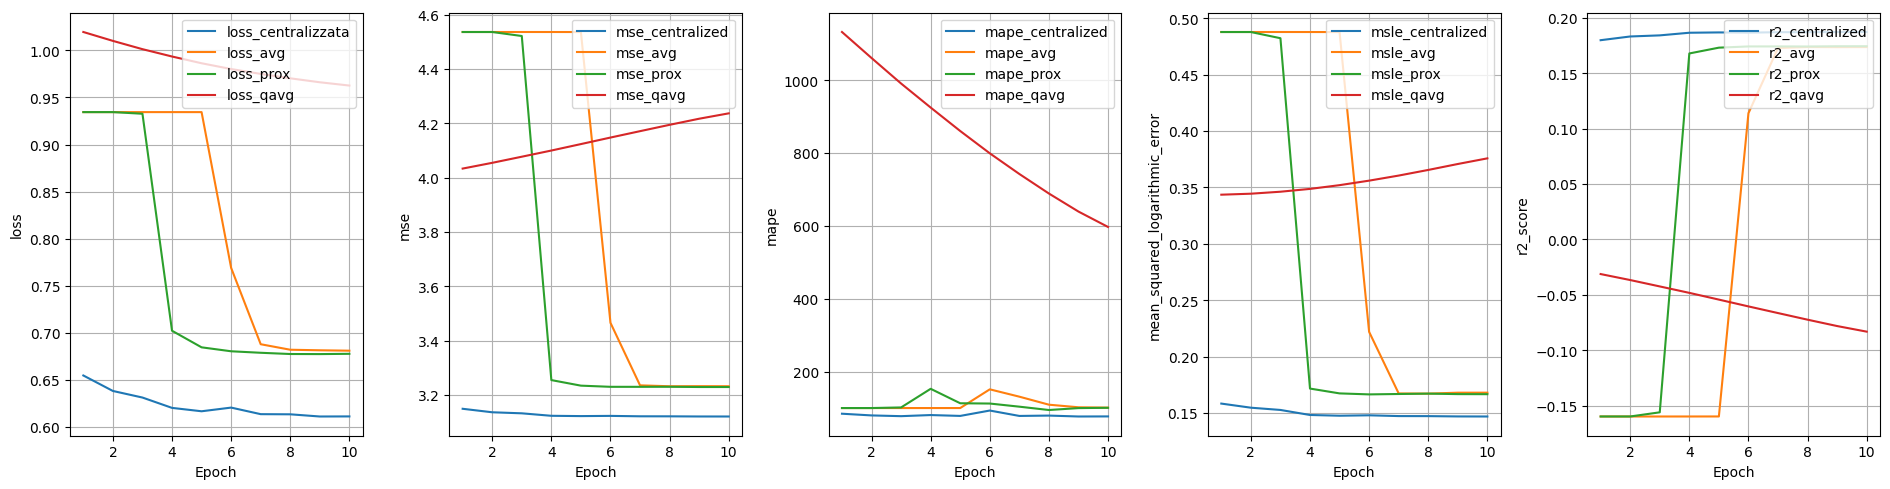

In [59]:
plot_loss(complete_h)

# SIMULAZIONE 100 CLIENTS

#### AVG

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})

h_avg = h_fedavg.drop(0)
h_avg = h_avg.rename(columns={'r2score': 'r2_avg', 'mse': 'mse_avg', 'mape': 'mape_avg', 'msle': 'msle_avg', 'loss (mae)': 'loss_avg'})
h_avg

In [39]:
data_average = [[0, 0, 0, 0, 0],
                [-0.159762,	4.536159,	100.017342,	0.487886,	0.934440],
                [-0.159751,	4.536115,	100.027443,	0.487866,	0.934436],
                [-0.010745,	3.953311,	120.919327,	0.337005,	0.857865],
                [0.172462,	3.236736,	154.915359,	0.167407,	0.691472],
                [0.173894,	3.231134,	125.122505,	0.166692,	0.683813],
                [0.172617,	3.236132,	102.653900,	0.169519,	0.685721],
                [0.174330,	3.229431,	99.786774,	0.166695,	0.678116],
                [0.174407,	3.229131,	96.671082,	0.166762,	0.676892],
                [0.174418,	3.229086,	93.692093,	0.166924,	0.676601],
                [0.174395,	3.229178,	99.611504,	0.166774,	0.677603]]

# Create the pandas DataFrame
h_average = pd.DataFrame(data_average, columns=['r2_avg', 'mse_avg', 'mape_avg', 'msle_avg','loss_avg']).drop(0)

h_average

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_avg,mse_avg,mape_avg,msle_avg,loss_avg
1,-0.159762,4.536159,100.017342,0.487886,0.934440
2,-0.159751,4.536115,100.027443,0.487866,0.934436
3,-0.010745,3.953311,120.919327,0.337005,0.857865
4,0.172462,3.236736,154.915359,0.167407,0.691472
5,0.173894,3.231134,125.122505,0.166692,0.683813
6,0.172617,3.236132,102.653900,0.169519,0.685721
7,0.174330,3.229431,99.786774,0.166695,0.678116
8,0.174407,3.229131,96.671082,0.166762,0.676892
9,0.174418,3.229086,93.692093,0.166924,0.676601
10,0.174395,3.229178,99.611504,0.166774,0.677603


#### PROX

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle_prox'})
h_prox = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss_prox'})

h_prox = h_prox.drop(0)
h_prox

In [41]:
data_proxima = [[0, 0, 0, 0, 0],
                [-0.159763,	4.536165,	100.014381,	0.487890,	0.934440],
                [-0.159770,	4.536192,	100.004097,	0.487902,	0.934440],
                [-0.159605,	4.535545,	100.172195,	0.487626,	0.934385],
                [0.158951,	3.289584,	164.696609,	0.180341,	0.719313],
                [0.173221,	3.233766,	120.342094,	0.166906,	0.685123],
                [0.174227,	3.229832,	115.213776,	0.166366,	0.680741],
                [0.174210,	3.229899,	103.767914,	0.166793,	0.678994],
                [0.174303,	3.229537,	98.336296,	0.166862,	0.677730],
                [0.174376,	3.229250,	103.581444,	0.166591,	0.678602],
                [0.174499,	3.228770,	97.098137,	0.166576,	0.676515]]

# Create the pandas DataFrame
h_proxima = pd.DataFrame(data_proxima, columns=['r2_prox', 'mse_prox', 'mape_prox', 'msle_prox','loss_prox']).drop(0)

h_proxima

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_prox,mse_prox,mape_prox,msle_prox,loss_prox
1,-0.159763,4.536165,100.014381,0.487890,0.934440
2,-0.159770,4.536192,100.004097,0.487902,0.934440
3,-0.159605,4.535545,100.172195,0.487626,0.934385
4,0.158951,3.289584,164.696609,0.180341,0.719313
5,0.173221,3.233766,120.342094,0.166906,0.685123
6,0.174227,3.229832,115.213776,0.166366,0.680741
7,0.174210,3.229899,103.767914,0.166793,0.678994
8,0.174303,3.229537,98.336296,0.166862,0.677730
9,0.174376,3.229250,103.581444,0.166591,0.678602
10,0.174499,3.228770,97.098137,0.166576,0.676515


#### QAVG

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedQavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})

h_qavg = h_fedQavg.drop(0)
h_qavg = h_qavg.rename(columns={'r2score': 'r2_qavg', 'mse': 'mse_qavg', 'mape': 'mape_qavg', 'msle': 'msle_qavg', 'loss (mae)': 'loss_qavg'})
h_qavg

In [43]:
data_qaverage = [ [0, 0, 0, 0, 0],
                [-0.028081,	4.021116,	1197.938110,0.344459,	1.028874],
                [-0.032804,	4.039591,	1130.297729,0.344599,	1.019577],
                [-0.037508,	4.057989,	1067.573975,0.345382,	1.011304],
                [-0.042762,	4.078539,	1002.637573,0.346941,	1.003132],
                [-0.048053,	4.099233,	941.212097,	0.349122,	0.995805],
                [-0.053511,	4.120582,	881.710938,	0.351962,	0.989066],
                [-0.058871,	4.141546,	826.227844,	0.355265,	0.983205],
                [-0.064044,	4.161779,	775.267151,	0.358906,	0.978397],
                [-0.069034,	4.181296,	728.122131,	0.362810,	0.974149],
                [-0.074444,	4.202457,	679.307861,	0.367464,	0.969918]]


 # Create the pandas DataFrame
h_qaverage = pd.DataFrame(data_qaverage, columns=['r2_qavg', 'mse_qavg', 'mape_qavg', 'msle_qavg','loss_qavg']).drop(0)

h_qaverage

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,r2_qavg,mse_qavg,mape_qavg,msle_qavg,loss_qavg
1,-0.028081,4.021116,1197.938110,0.344459,1.028874
2,-0.032804,4.039591,1130.297729,0.344599,1.019577
3,-0.037508,4.057989,1067.573975,0.345382,1.011304
4,-0.042762,4.078539,1002.637573,0.346941,1.003132
5,-0.048053,4.099233,941.212097,0.349122,0.995805
6,-0.053511,4.120582,881.710938,0.351962,0.989066
7,-0.058871,4.141546,826.227844,0.355265,0.983205
8,-0.064044,4.161779,775.267151,0.358906,0.978397
9,-0.069034,4.181296,728.122131,0.362810,0.974149
10,-0.074444,4.202457,679.307861,0.367464,0.969918


#### COMPLETE

In [44]:
complete_h = pd.concat([h_centrale, h_average], axis=1)
complete_h = pd.concat([complete_h, h_proxima], axis=1)
complete_h = pd.concat([complete_h, h_qaverage], axis=1)

complete_h = complete_h.iloc[:,[0,1,10,15,20,2,7,12,17,3,8,13,18,4,9,14,19,5,6,11,16]]

pd.set_option('display.max_columns', None)
complete_h

,epoch,c_loss,loss_avg,loss_prox,loss_qavg,c_mse,mse_avg,mse_prox,mse_qavg,c_mape,mape_avg,mape_prox,mape_qavg,c_msle,msle_avg,msle_prox,msle_qavg,c_r2,r2_avg,r2_prox,r2_qavg
1,1,0.654691,0.934440,0.934440,1.028874,3.148931,4.536159,4.536165,4.021116,84.439003,100.017342,100.014381,1197.938110,0.158293,0.487886,0.487890,0.344459,0.179876,-0.159762,-0.159763,-0.028081
2,2,0.638235,0.934436,0.934440,1.019577,3.136050,4.536115,4.536192,4.039591,79.750023,100.027443,100.004097,1130.297729,0.154645,0.487866,0.487902,0.344599,0.183230,-0.159751,-0.159770,-0.032804
3,3,0.631250,0.857865,0.934385,1.011304,3.132224,3.953311,4.535545,4.057989,77.709427,120.919327,100.172195,1067.573975,0.152647,0.337005,0.487626,0.345382,0.184227,-0.010745,-0.159605,-0.037508
4,4,0.620261,0.691472,0.719313,1.003132,3.123100,3.236736,3.289584,4.078539,80.765099,154.915359,164.696609,1002.637573,0.148184,0.167407,0.180341,0.346941,0.186603,0.172462,0.158951,-0.042762
5,5,0.616670,0.683813,0.685123,0.995805,3.121987,3.231134,3.233766,4.099233,78.399124,125.122505,120.342094,941.212097,0.147527,0.166692,0.166906,0.349122,0.186893,0.173894,0.173221,-0.048053
6,6,0.620576,0.685721,0.680741,0.989066,3.122755,3.236132,3.229832,4.120582,93.155891,102.653900,115.213776,881.710938,0.147896,0.169519,0.166366,0.351962,0.186693,0.172617,0.174227,-0.053511
7,7,0.613600,0.678116,0.678994,0.983205,3.121242,3.229431,3.229899,4.141546,78.342842,99.786774,103.767914,826.227844,0.147210,0.166695,0.166793,0.355265,0.187087,0.174330,0.174210,-0.058871
8,8,0.613441,0.676892,0.677730,0.978397,3.121131,3.229131,3.229537,4.161779,79.306496,96.671082,98.336296,775.267151,0.147167,0.166762,0.166862,0.358906,0.187116,0.174407,0.174303,-0.064044
9,9,0.611118,0.676601,0.678602,0.974149,3.120584,3.229086,3.229250,4.181296,76.801743,93.692093,103.581444,728.122131,0.146897,0.166924,0.166591,0.362810,0.187258,0.174418,0.174376,-0.069034
10,10,0.611208,0.677603,0.676515,0.969918,3.120517,3.229178,3.228770,4.202457,77.030296,99.611504,97.098137,679.307861,0.146838,0.166774,0.166576,0.367464,0.187276,0.174395,0.174499,-0.074444


#### GRAFICI

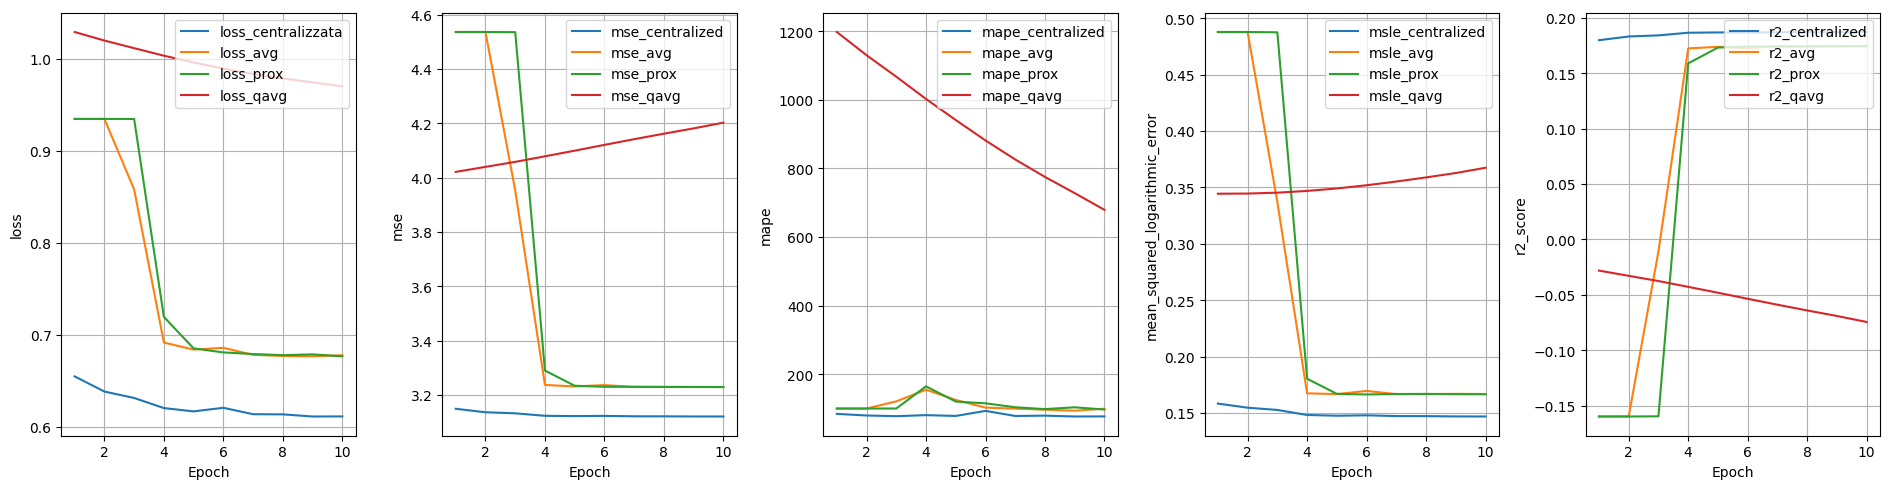

In [48]:
plot_loss(complete_h)

# SIMULAZIONE 5 CLIENTS

#### AVG

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})

h_avg = h_fedavg.drop(0)
h_avg = h_avg.rename(columns={'r2score': 'r2_avg', 'mse': 'mse_avg', 'mape': 'mape_avg', 'msle': 'msle_avg', 'loss (mae)': 'loss_avg'})
h_avg

In [13]:
data_average = [[0, 0, 0, 0, 0],
              [-0.159761,	4.536157,	100.018013,	0.487885,	0.934440],
              [-0.159770,	4.536190,	100.004211,	0.487901,	0.934439],
              [-0.021143,	3.993981,	142.458313,	0.336076,	0.859795],
              [0.172017,	3.238478,	146.970963,	0.167514,	0.692061],
              [0.171290,	3.241322,	102.633942,	0.170859,	0.691448],
              [0.173558,	3.232451,	136.325989,	0.167391,	0.686669],
              [0.173954,	3.230900,	110.919678,	0.167135,	0.681744],
              [0.174311,	3.229506,	107.465851,	0.166582,	0.679692],
              [0.174057,	3.230500,	97.226883,	0.167189,	0.678425],
              [0.173841,	3.231344,	91.199471,	0.167720,	0.678816]]

# Create the pandas DataFrame
h_average = pd.DataFrame(data_average, columns=['r2_avg', 'mse_avg', 'mape_avg', 'msle_avg','loss_avg']).drop(0)

h_average

,r2_avg,mse_avg,mape_avg,msle_avg,loss_avg
1,-0.159761,4.536157,100.018013,0.487885,0.934440
2,-0.159770,4.536190,100.004211,0.487901,0.934439
3,-0.021143,3.993981,142.458313,0.336076,0.859795
4,0.172017,3.238478,146.970963,0.167514,0.692061
5,0.171290,3.241322,102.633942,0.170859,0.691448
6,0.173558,3.232451,136.325989,0.167391,0.686669
7,0.173954,3.230900,110.919678,0.167135,0.681744
8,0.174311,3.229506,107.465851,0.166582,0.679692
9,0.174057,3.230500,97.226883,0.167189,0.678425
10,0.173841,3.231344,91.199471,0.167720,0.678816


#### PROX

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape_prox'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle_prox'})
h_prox = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss_prox'})

h_prox = h_prox.drop(0)
h_prox

In [14]:
data_proxima = [[0, 0, 0, 0, 0],
[-0.159773,	4.536203,	99.999855,	0.487908,	0.934440],
[-0.159774,	4.536207,	99.999794,	0.487911,	0.934440],
[-0.159774,	4.536207,	99.999763,	0.487911,	0.934440],
[-0.159774,	4.536206,	99.999771,	0.487911,	0.934440],
[-0.159774,	4.536206,	99.999741,	0.487910,	0.934440],
[-0.159772,	4.536198,	100.001678,	0.487906,	0.934440],
[-0.159551,	4.535333,	100.222649,	0.487544,	0.934361],
[0.160283,	3.284371,	167.063980,	0.179870,	0.717523],
[0.173352,	3.233256,	119.677078,	0.166866,	0.684452],
[0.174031,	3.230598,	109.033409,	0.166734,	0.680655]]

# Create the pandas DataFrame
h_proxima = pd.DataFrame(data_proxima, columns=['r2_prox', 'mse_prox', 'mape_prox', 'msle_prox','loss_prox']).drop(0)

h_proxima

,r2_prox,mse_prox,mape_prox,msle_prox,loss_prox
1,-0.159773,4.536203,99.999855,0.487908,0.934440
2,-0.159774,4.536207,99.999794,0.487911,0.934440
3,-0.159774,4.536207,99.999763,0.487911,0.934440
4,-0.159774,4.536206,99.999771,0.487911,0.934440
5,-0.159774,4.536206,99.999741,0.487910,0.934440
6,-0.159772,4.536198,100.001678,0.487906,0.934440
7,-0.159551,4.535333,100.222649,0.487544,0.934361
8,0.160283,3.284371,167.063980,0.179870,0.717523
9,0.173352,3.233256,119.677078,0.166866,0.684452
10,0.174031,3.230598,109.033409,0.166734,0.680655


#### QAVG

In [ ]:
h = pd.DataFrame(history.metrics_centralized['R2Score']).drop([0], axis=1).rename(columns={1: 'r2score'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mse']).drop([0], axis=1)], axis=1).rename(columns={1: 'mse'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mape']).drop([0], axis=1)], axis=1).rename(columns={1: 'mape'})
h = pd.concat([h, pd.DataFrame(history.metrics_centralized['mean_squared_logarithmic_error']).drop([0], axis=1)], axis=1).rename(columns={1: 'msle'})
h_fedQavg = pd.concat([h, pd.DataFrame(history.losses_centralized).drop([0], axis=1)], axis=1).rename(columns={1: 'loss (mae)'})

h_qavg = h_fedQavg.drop(0)
h_qavg = h_qavg.rename(columns={'r2score': 'r2_qavg', 'mse': 'mse_qavg', 'mape': 'mape_qavg', 'msle': 'msle_qavg', 'loss (mae)': 'loss_qavg'})
h_qavg

In [15]:
data_qaverage = [ [0, 0, 0, 0, 0],
                [-0.023812,	4.004421,	1245.078613,	0.343961,	1.034860],
                [-0.028661,	4.023385,	1170.739014,	0.343543,	1.024320],
                [-0.033797,	4.043476,	1098.969849,	0.343977,	1.014603],
                [-0.039113,	4.064268,	1030.530273,	0.345203,	1.005769],
                [-0.044522,	4.085424,	965.856934,	0.347147,	0.997864],
                [-0.050337,	4.108167,	900.990173,	0.349924,	0.990390],
                [-0.056355,	4.131704,	838.030029,	0.353459,	0.983633],
                [-0.062189,	4.154524,	780.382446,	0.357464,	0.978149],
                [-0.068092,	4.177613,	725.056152,	0.362057,	0.973190],
                [-0.073753,	4.199753,	674.391663,	0.366939,	0.968814]]


 # Create the pandas DataFrame
h_qaverage = pd.DataFrame(data_qaverage, columns=['r2_qavg', 'mse_qavg', 'mape_qavg', 'msle_qavg','loss_qavg']).drop(0)

h_qaverage

,r2_qavg,mse_qavg,mape_qavg,msle_qavg,loss_qavg
1,-0.023812,4.004421,1245.078613,0.343961,1.034860
2,-0.028661,4.023385,1170.739014,0.343543,1.024320
3,-0.033797,4.043476,1098.969849,0.343977,1.014603
4,-0.039113,4.064268,1030.530273,0.345203,1.005769
5,-0.044522,4.085424,965.856934,0.347147,0.997864
6,-0.050337,4.108167,900.990173,0.349924,0.990390
7,-0.056355,4.131704,838.030029,0.353459,0.983633
8,-0.062189,4.154524,780.382446,0.357464,0.978149
9,-0.068092,4.177613,725.056152,0.362057,0.973190
10,-0.073753,4.199753,674.391663,0.366939,0.968814


#### COMPLETE

In [16]:
complete_h = pd.concat([h_centrale, h_average], axis=1)
complete_h = pd.concat([complete_h, h_proxima], axis=1)
complete_h = pd.concat([complete_h, h_qaverage], axis=1)

complete_h = complete_h.iloc[:,[0,1,10,15,20,2,7,12,17,3,8,13,18,4,9,14,19,5,6,11,16]]

pd.set_option('display.max_columns', None)
complete_h

,epoch,c_loss,loss_avg,loss_prox,loss_qavg,c_mse,mse_avg,mse_prox,mse_qavg,c_mape,mape_avg,mape_prox,mape_qavg,c_msle,msle_avg,msle_prox,msle_qavg,c_r2,r2_avg,r2_prox,r2_qavg
1,1,0.654691,0.934440,0.934440,1.034860,3.148931,4.536157,4.536203,4.004421,84.439003,100.018013,99.999855,1245.078613,0.158293,0.487885,0.487908,0.343961,0.179876,-0.159761,-0.159773,-0.023812
2,2,0.638235,0.934439,0.934440,1.024320,3.136050,4.536190,4.536207,4.023385,79.750023,100.004211,99.999794,1170.739014,0.154645,0.487901,0.487911,0.343543,0.183230,-0.159770,-0.159774,-0.028661
3,3,0.631250,0.859795,0.934440,1.014603,3.132224,3.993981,4.536207,4.043476,77.709427,142.458313,99.999763,1098.969849,0.152647,0.336076,0.487911,0.343977,0.184227,-0.021143,-0.159774,-0.033797
4,4,0.620261,0.692061,0.934440,1.005769,3.123100,3.238478,4.536206,4.064268,80.765099,146.970963,99.999771,1030.530273,0.148184,0.167514,0.487911,0.345203,0.186603,0.172017,-0.159774,-0.039113
5,5,0.616670,0.691448,0.934440,0.997864,3.121987,3.241322,4.536206,4.085424,78.399124,102.633942,99.999741,965.856934,0.147527,0.170859,0.487910,0.347147,0.186893,0.171290,-0.159774,-0.044522
6,6,0.620576,0.686669,0.934440,0.990390,3.122755,3.232451,4.536198,4.108167,93.155891,136.325989,100.001678,900.990173,0.147896,0.167391,0.487906,0.349924,0.186693,0.173558,-0.159772,-0.050337
7,7,0.613600,0.681744,0.934361,0.983633,3.121242,3.230900,4.535333,4.131704,78.342842,110.919678,100.222649,838.030029,0.147210,0.167135,0.487544,0.353459,0.187087,0.173954,-0.159551,-0.056355
8,8,0.613441,0.679692,0.717523,0.978149,3.121131,3.229506,3.284371,4.154524,79.306496,107.465851,167.063980,780.382446,0.147167,0.166582,0.179870,0.357464,0.187116,0.174311,0.160283,-0.062189
9,9,0.611118,0.678425,0.684452,0.973190,3.120584,3.230500,3.233256,4.177613,76.801743,97.226883,119.677078,725.056152,0.146897,0.167189,0.166866,0.362057,0.187258,0.174057,0.173352,-0.068092
10,10,0.611208,0.678816,0.680655,0.968814,3.120517,3.231344,3.230598,4.199753,77.030296,91.199471,109.033409,674.391663,0.146838,0.167720,0.166734,0.366939,0.187276,0.173841,0.174031,-0.073753


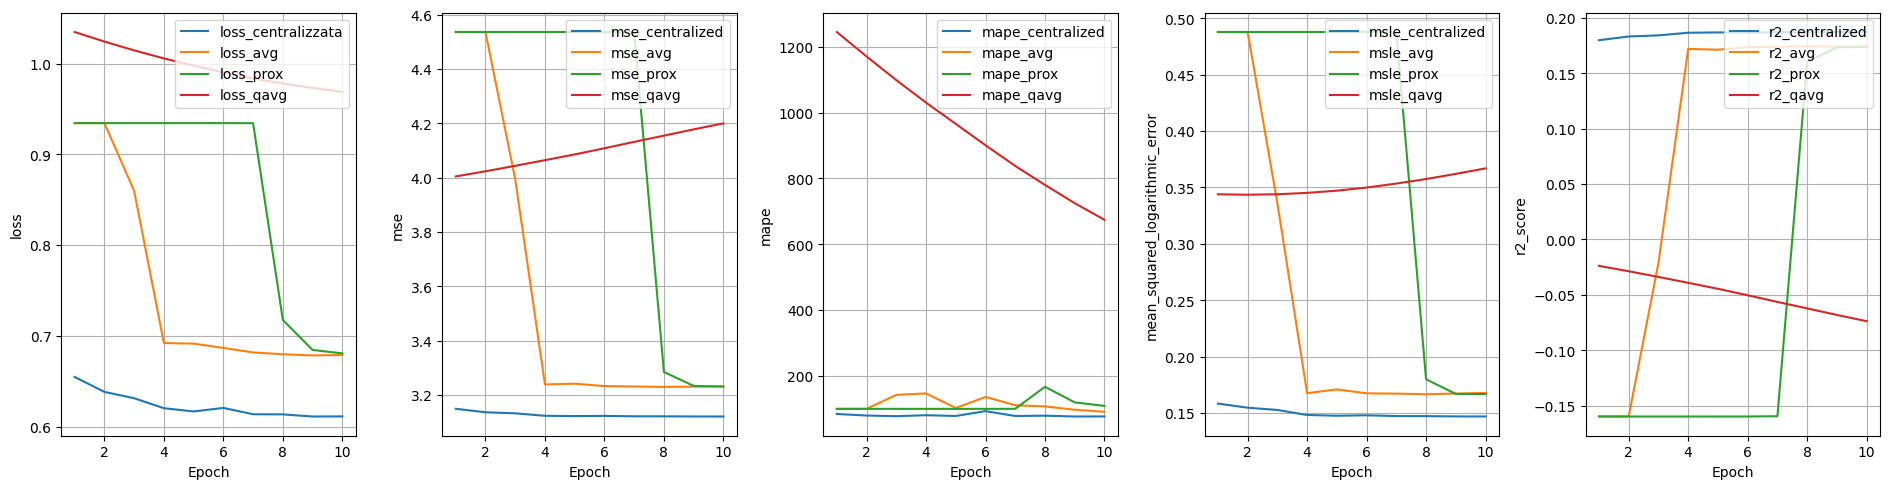

In [17]:
plot_loss(complete_h)